In [5]:
#Very Important to understand these

# https://pypi.org/project/pyportfolioopt/
# https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html
# https://pyportfolioopt.readthedocs.io/en/latest/OtherOptimizers.html

# https://cvxopt.org/index.html

#### 1

#### 2

#### 3

#### 4 

#### Approach 1

Here is an example on real life stock data, demonstrating how easy it is to find the long-only portfolio that maximises the Sharpe ratio (a measure of risk-adjusted returns).

In [3]:
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# Read in price data
df = pd.read_csv("stock_prices.csv", parse_dates=True, index_col="date")

In [8]:
df.head()

,GOOG,AAPL,FB,BABA,AMZN,GE,AMD,WMT,BAC,GM,T,UAA,SHLD,XOM,RRC,BBY,MA,PFE,JPM,SBUX
date,,,,,,,,,,,,,,,,,,,,
1989-12-29,NaN,0.117203,NaN,NaN,NaN,0.352438,3.9375,3.486070,1.752478,NaN,2.365775,NaN,NaN,1.766756,NaN,0.166287,NaN,0.110818,1.827968,NaN
1990-01-02,NaN,0.123853,NaN,NaN,NaN,0.364733,4.1250,3.660858,1.766686,NaN,2.398184,NaN,NaN,1.766756,NaN,0.173216,NaN,0.113209,1.835617,NaN
1990-01-03,NaN,0.124684,NaN,NaN,NaN,0.364050,4.0000,3.660858,1.780897,NaN,2.356516,NaN,NaN,1.749088,NaN,0.194001,NaN,0.113608,1.896803,NaN
1990-01-04,NaN,0.125100,NaN,NaN,NaN,0.362001,3.9375,3.641439,1.743005,NaN,2.403821,NaN,NaN,1.731422,NaN,0.190537,NaN,0.115402,1.904452,NaN
1990-01-05,NaN,0.125516,NaN,NaN,NaN,0.358586,3.8125,3.602595,1.705114,NaN,2.287973,NaN,NaN,1.722587,NaN,0.190537,NaN,0.114405,1.912100,NaN


In [ ]:
#expected_returns()
# By convention, the output of these methods is expected *annual* returns. It is assumed that
# *daily* prices are provided, though in reality the functions are agnostic
# to the time period (just change the ``frequency`` parameter). Asset prices must be given as
# a pandas dataframe, as per the format described in the :ref:`user-guide`.
# All of the functions process the price data into percentage returns data, before
# calculating their respective estimates of expected returns.

# Currently implemented:

#     - general return model function, allowing you to run any return model from one function.
#     - mean historical return
#     - exponentially weighted mean historical return
#     - CAPM estimate of returns

# Additionally, we provide utility functions to convert from returns to prices and vice-versa.

In [9]:
# risk_models()
# The ``risk_models`` module provides functions for estimating the covariance matrix given
# historical returns.

# The format of the data input is the same as that in :ref:`expected-returns`.

# **Currently implemented:**

# - fix non-positive semidefinite matrices
# - general risk matrix function, allowing you to run any risk model from one function.
# - sample covariance
# - semicovariance
# - exponentially weighted covariance
# - minimum covariance determinant
# - shrunk covariance matrices:

#     - manual shrinkage
#     - Ledoit Wolf shrinkage
#     - Oracle Approximating shrinkage

# - covariance to correlation matrix

In [2]:
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)





In [3]:
# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe() #optimizes for maximal Sharpe ratio (a.k.a the tangency portfolio), check other options in EfficientFrontier()
cleaned_weights = ef.clean_weights() #rounds the weights and clips near-zeros.
ef.save_weights_to_file("weights.csv")  # saves to file
print(cleaned_weights)
ef.portfolio_performance(verbose=True) #calculates the expected return, volatility and Sharpe ratio for the optimized portfolio.

OrderedDict([('GOOG', 0.0458), ('AAPL', 0.06743), ('FB', 0.2008), ('BABA', 0.08494), ('AMZN', 0.03525), ('GE', 0.0), ('AMD', 0.0), ('WMT', 0.0), ('BAC', 0.0), ('GM', 0.0), ('T', 0.0), ('UAA', 0.0), ('SHLD', 0.0), ('XOM', 0.0), ('RRC', 0.0), ('BBY', 0.01587), ('MA', 0.3287), ('PFE', 0.20394), ('JPM', 0.0), ('SBUX', 0.01726)])
Expected annual return: 29.9%
Annual volatility: 21.8%
Sharpe Ratio: 1.38


(np.float64(0.2994470916123031),
 np.float64(0.2176433168139341),
 np.float64(1.375861643701672))

This is interesting but not useful in itself. However, PyPortfolioOpt provides a method which allows you to convert the above continuous weights to an actual allocation that you could buy. Just enter the most recent prices, and the desired portfolio size ($10,000 in this example):

In [7]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices


latest_prices = get_latest_prices(df)

da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'MA': 19, 'PFE': 57, 'FB': 12, 'BABA': 4, 'AAPL': 4, 'GOOG': 1, 'SBUX': 2, 'BBY': 2}
Funds remaining: $17.46


Adding constraints or different objectives

    Long/short: by default all of the mean-variance optimization methods in PyPortfolioOpt are long-only, but they can be initialised to allow for short positions by changing the weight bounds:

ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))

    Market neutrality: for the efficient_risk and efficient_return methods, PyPortfolioOpt provides an option to form a market-neutral portfolio (i.e weights sum to zero). This is not possible for the max Sharpe portfolio and the min volatility portfolio because in those cases because they are not invariant with respect to leverage. Market neutrality requires negative weights:

ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
ef.efficient_return(target_return=0.2, market_neutral=True)

    Minimum/maximum position size: it may be the case that you want no security to form more than 10% of your portfolio. This is easy to encode:

ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.1))

One issue with mean-variance optimization is that it leads to many zero-weights. While these are "optimal" in-sample, there is a large body of research showing that this characteristic leads mean-variance portfolios to underperform out-of-sample. To that end, I have introduced an objective function that can reduce the number of negligible weights for any of the objective functions. Essentially, it adds a penalty (parameterised by gamma) on small weights, with a term that looks just like L2 regularisation in machine learning. It may be necessary to try several gamma values to achieve the desired number of non-negligible weights. For the test portfolio of 20 securities, gamma ~ 1 is sufficient

ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=1)
ef.max_sharpe()

Black-Litterman allocation

As of v0.5.0, we now support Black-Litterman asset allocation, which allows you to combine a prior estimate of returns (e.g the market-implied returns) with your own views to form a posterior estimate. This results in much better estimates of expected returns than just using the mean historical return. Check out the docs for a discussion of the theory, as well as advice on formatting inputs.

S = risk_models.sample_cov(df)
viewdict = {"AAPL": 0.20, "BBY": -0.30, "BAC": 0, "SBUX": -0.2, "T": 0.131321}
bl = BlackLittermanModel(S, pi="equal", absolute_views=viewdict, omega="default")
rets = bl.bl_returns()

ef = EfficientFrontier(rets, S)
ef.max_sharpe()


Adding constraints or different objectives

    Long/short: by default all of the mean-variance optimization methods in PyPortfolioOpt are long-only, but they can be initialised to allow for short positions by changing the weight bounds:

ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))

    Market neutrality: for the efficient_risk and efficient_return methods, PyPortfolioOpt provides an option to form a market-neutral portfolio (i.e weights sum to zero). This is not possible for the max Sharpe portfolio and the min volatility portfolio because in those cases because they are not invariant with respect to leverage. Market neutrality requires negative weights:

ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
ef.efficient_return(target_return=0.2, market_neutral=True)

    Minimum/maximum position size: it may be the case that you want no security to form more than 10% of your portfolio. This is easy to encode:

ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.1))

One issue with mean-variance optimization is that it leads to many zero-weights. While these are "optimal" in-sample, there is a large body of research showing that this characteristic leads mean-variance portfolios to underperform out-of-sample. To that end, I have introduced an objective function that can reduce the number of negligible weights for any of the objective functions. Essentially, it adds a penalty (parameterised by gamma) on small weights, with a term that looks just like L2 regularisation in machine learning. It may be necessary to try several gamma values to achieve the desired number of non-negligible weights. For the test portfolio of 20 securities, gamma ~ 1 is sufficient

ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=1)
ef.max_sharpe()

Black-Litterman allocation

As of v0.5.0, we now support Black-Litterman asset allocation, which allows you to combine a prior estimate of returns (e.g the market-implied returns) with your own views to form a posterior estimate. This results in much better estimates of expected returns than just using the mean historical return. Check out the docs for a discussion of the theory, as well as advice on formatting inputs.

S = risk_models.sample_cov(df)
viewdict = {"AAPL": 0.20, "BBY": -0.30, "BAC": 0, "SBUX": -0.2, "T": 0.131321}
bl = BlackLittermanModel(S, pi="equal", absolute_views=viewdict, omega="default")
rets = bl.bl_returns()

ef = EfficientFrontier(rets, S)
ef.max_sharpe()


#### Approach 2

In [152]:
%matplotlib inline
import yfinance as yf
from zipline import run_algorithm 
from zipline.api import order_target_percent, symbol, set_commission, schedule_function, date_rules, time_rules
from zipline.finance.commission import PerTrade
import pandas as pd
import pyfolio as pf
from scipy.optimize import minimize
import numpy as np


import warnings
warnings.filterwarnings('ignore')


    
def minimum_vol_obj(wo, cov):
    w = wo.reshape(-1, 1)
    sig_p = np.sqrt(np.matmul(w.T, np.matmul(cov, w)))[0, 0]
    return sig_p

In [154]:
stocks = ['AAPL',       # Apple
          'KO',         # Coca-Cola
          'DIS',        # Disney
          'XOM',        # Exxon Mobil
          'JPM',        # JPMorgan Chase
          'MCD',        # McDonald's
          'WMT']         # Walmart

In [155]:
prices = None
n_stocks = len(stocks)
for i in range(n_stocks):
        price_history = yf.download(stocks[i],multi_level_index=False,auto_adjust=False)
        price_history = price_history.loc[(price_history.index > '2015-01-01') & (price_history.index < '2019-01-01')]
        price = np.array(price_history['Adj Close'])
        if prices is None:
            prices = price
        else:
            prices = np.c_[prices, price] #concatinates prices column wise
    
rets = prices[1:,:]/prices[0:-1, :]-1.0 #cool way for data manipulation or np.log(hist_data / hist_data.shift()) 
                                        #hist_return.cov()
mu = np.mean(rets, axis=0)
cov = np.cov(rets.T)    #check the dfinition of np.cov() to understand why we took rets.T

w0 = np.ones(n_stocks) / n_stocks #initial equal weights

#constraints and tolerance defined below
cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}, {'type': 'ineq', 'fun': lambda w: w})
TOL = 1e-12    
res = minimize(minimum_vol_obj, w0, args=cov, method='SLSQP', 
               constraints=cons, tol=TOL, options={'disp': False})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [156]:
pd.DataFrame(np.array(res.x).reshape(1, n_stocks), columns = stocks)

,AAPL,KO,DIS,XOM,JPM,MCD,WMT
0,0.034549,0.480389,0.118567,0.091615,0.013324,0.162403,0.099153


#### Approach 3

In [ ]:
#https://letianzj.github.io/portfolio-management-one.html

In [ ]:
# below is on adj.close from quandl data source

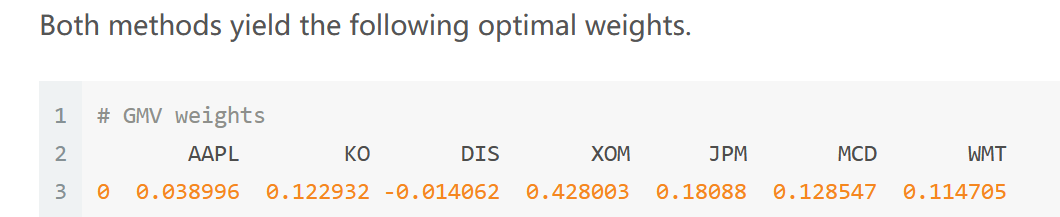

In [157]:
assets = ['AAPL',       # Apple
          'KO',         # Coca-Cola
          'DIS',        # Disney
          'XOM',        # Exxon Mobil
          'JPM',        # JPMorgan Chase
          'MCD',        # McDonald's
          'WMT']         # Walmart

# download historical data from quandl
hist_data = {}
for asset in assets:
    data = yf.download(asset, start='2015-01-01', end='2017-12-31',multi_level_index=False,auto_adjust =False)
    hist_data[asset] = data['Adj Close']
hist_data = pd.concat(hist_data, axis=1)

# calculate historical log returns
hist_return = np.log(hist_data / hist_data.shift())
hist_return = hist_return.dropna()

# find historical mean, covriance, and correlation
hist_mean = hist_return.mean(axis=0).to_frame()
hist_mean.columns = ['mu']
hist_cov = hist_return.cov()
hist_corr = hist_return.corr()
print(hist_mean.transpose())
print(hist_cov)
print(hist_corr)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

        AAPL        KO       DIS       XOM       JPM       MCD       WMT
mu  0.000652  0.000242  0.000238  0.000002  0.000808  0.000932  0.000293
          AAPL        KO       DIS       XOM       JPM       MCD       WMT
AAPL  0.000208  0.000032  0.000055  0.000051  0.000076  0.000044  0.000038
KO    0.000032  0.000065  0.000030  0.000033  0.000032  0.000035  0.000030
DIS   0.000055  0.000030  0.000138  0.000048  0.000072  0.000032  0.000031
XOM   0.000051  0.000033  0.000048  0.000132  0.000080  0.000036  0.000028
JPM   0.000076  0.000032  0.000072  0.000080  0.000180  0.000051  0.000038
MCD   0.000044  0.000035  0.000032  0.000036  0.000051  0.000101  0.000032
WMT   0.000038  0.000030  0.000031  0.000028  0.000038  0.000032  0.000150
          AAPL        KO       DIS       XOM       JPM       MCD       WMT
AAPL  1.000000  0.277772  0.324263  0.308125  0.390814  0.305938  0.215721
KO    0.277772  1.000000  0.313574  0.357595  0.293825  0.426696  0.307808
DIS   0.324263  0.313574  1.0

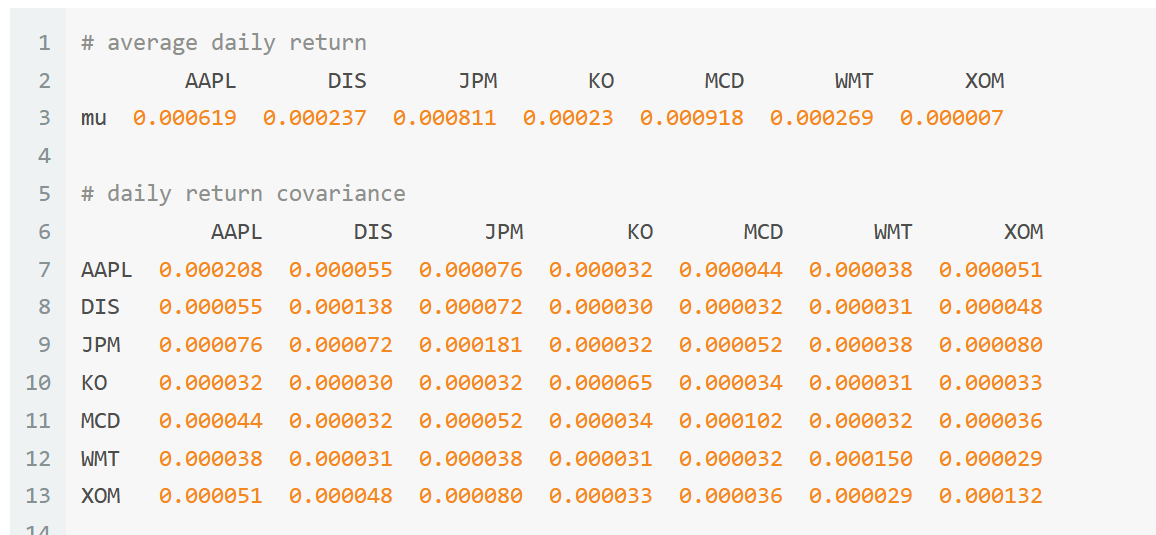


In [19]:
# import quandl #use nasdaq-data link instead
# # quandl.ApiConfig.api_key = os.environ["QUANDL_API_KEY"]
# import  nasdaqdatalink as Nasdaqdatalink
# Nasdaqdatalink.ApiConfig.api_key = 'fzAk_-G6UKXM8X9qtG9o'
# Nasdaqdatalink.get('WIKI/AAPL.4',start_date='2023-12-31', end_date = '2024-05-01')

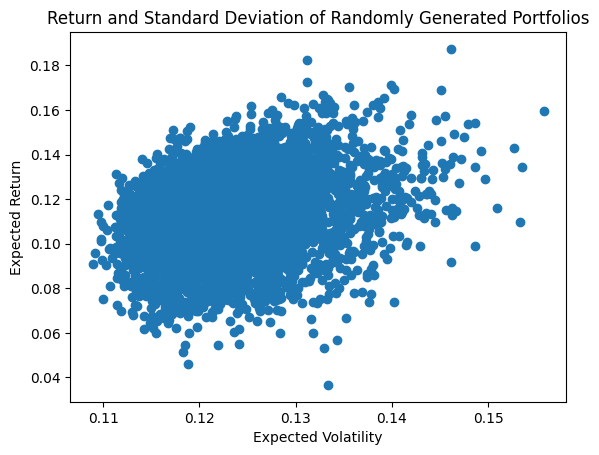

In [158]:
import matplotlib.pyplot as plt
# construct random portfolios
n_portfolios = 5000
#set up array to hold results
port_returns = np.zeros(n_portfolios)
port_stdevs = np.zeros(n_portfolios)

for i in range(n_portfolios):
    w = np.random.rand(len(stocks))        # random weights
    w = w / sum(w)                         # weights sum to 1
    port_return = np.dot(w.T, hist_mean) * 250         # annualize; 250 business days
    port_stdev = np.sqrt(np.dot(w.T, np.dot(hist_cov, w))) * np.sqrt(250)  # annualize; 250 business days
    port_returns[i] = port_return
    port_stdevs[i] = port_stdev

plt.plot(port_stdevs, port_returns, 'o', markersize=6)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Return and Standard Deviation of Randomly Generated Portfolios')
plt.show()

In [159]:
hist_cov_inv = - np.linalg.inv(hist_cov)
one_vec = np.ones(len(assets))
w_gmv = np.dot(hist_cov_inv, one_vec) / (np.dot(np.transpose(one_vec), np.dot(hist_cov_inv, one_vec)))
w_gmv_df = pd.DataFrame(data = w_gmv).transpose()
w_gmv_df.columns = assets
stdev_gmv = np.sqrt(np.dot(w_gmv.T, np.dot(hist_cov, w_gmv))) * np.sqrt(250)
print(w_gmv_df)
print(stdev_gmv)

       AAPL        KO      DIS       XOM       JPM       MCD       WMT
0  0.037917  0.426977  0.12536  0.115104 -0.014244  0.179344  0.129543
0.10748240038846339


In [187]:
# solvers.qp()

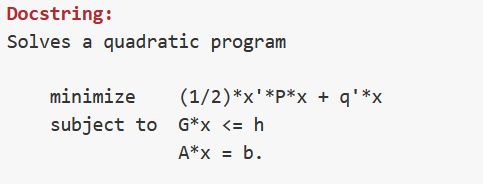

In [160]:
# Global Minimum Variance (GMV) -- numerical
from cvxopt import matrix, solvers

P = matrix(np.array(hist_cov))
q = matrix(np.zeros((len(assets), 1))) #cvqopt.matrix of 0s of shape (7, 1)
A = matrix(1.0, (1, len(assets))) #cvqopt.matrix of 1s of shape (1, 7) 
b = matrix(1.0) #1x1 matrix of 1
w_gmv_v2 = np.array(solvers.qp(P, q, A=A, b=b)['x']) #minimizes volatility such that sum of x = 1
w_gmv_df_v2 = pd.DataFrame(w_gmv_v2).transpose()
w_gmv_df_v2.columns = assets
stdev_gmv_v2 = np.sqrt(np.dot(w_gmv_v2.T, np.dot(hist_cov, w_gmv_v2))) * np.sqrt(250)
print(w_gmv_df_v2)
# print(np.asscalar(stdev_gmv_v2))

       AAPL        KO      DIS       XOM       JPM       MCD       WMT
0  0.037917  0.426977  0.12536  0.115104 -0.014244  0.179344  0.129543


In [199]:
# np.array(hist_cov)

In [186]:
b

<1x1 matrix, tc='d'>

#### Optimization in Asset Management

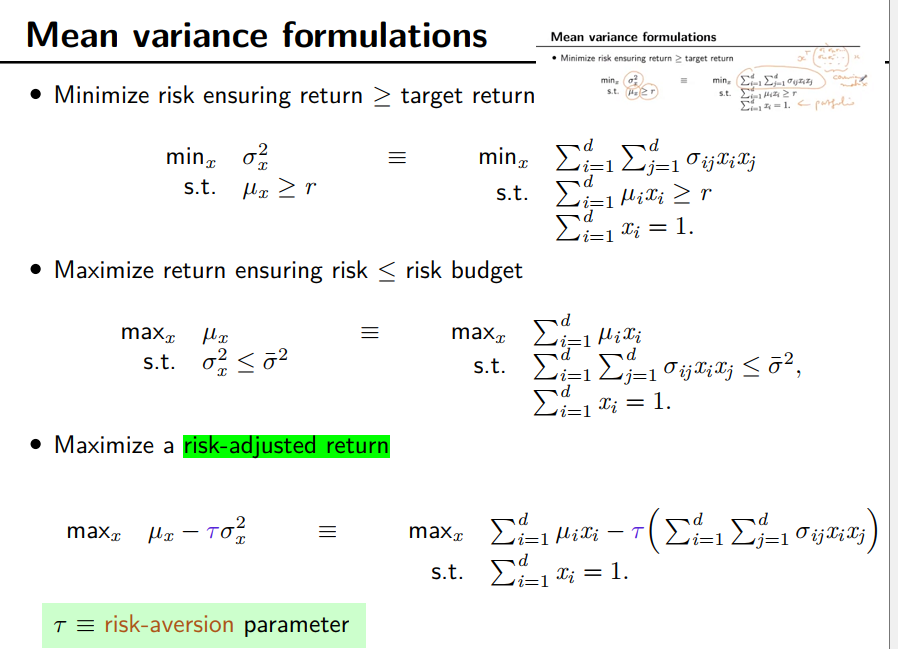

In [1]:
import os
os.getcwd()

'C:\\Users\\avi\\Possible_Project'

In [5]:
mvo1 = pd.read_excel('mvo.xlsx',sheet_name = 'data')

In [13]:
mvo1

,Unnamed: 0,US Bonds,Int’l Bonds,US Large Growth,US Large Value,US Small Growth,US Small Value,Int’l Dev. Equity,Int’l Emerg. Equity,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,Mean return,3.15,1.75,-6.39,-2.86,-6.75,-0.54,-6.75,-5.26,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Covariance matrix,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,US Bonds,Int’l Bonds,US Large Growth,US Large Value,US Small Growth,US Small Value,Int’l Dev. Equity,Int’l Emerg. Equity,NaN,NaN,NaN
4,US Bonds,0.001005,0.001328,-0.000579,-0.000675,0.000121,0.000128,-0.000445,-0.000437,NaN,NaN,NaN
5,Int’l Bonds,0.001328,0.007277,-0.001307,-0.00061,-0.002237,-0.000989,0.001442,-0.001535,NaN,NaN,NaN
6,US Large Growth,-0.000579,-0.001307,0.059852,0.027588,0.063497,0.023036,0.032967,0.048039,NaN,NaN,NaN
7,US Large Value,-0.000675,-0.00061,0.027588,0.029609,0.026572,0.021465,0.020697,0.029854,NaN,NaN,NaN
8,US Small Growth,0.000121,-0.002237,0.063497,0.026572,0.102488,0.042744,0.039943,0.065994,NaN,NaN,NaN
9,US Small Value,0.000128,-0.000989,0.023036,0.021465,0.042744,0.032056,0.019881,0.032235,NaN,NaN,NaN


In [204]:
mvo1_mean = np.array(mvo1.iloc[0, 1:9].values).astype(float)
mvo1_cov = np.array(mvo1.iloc[4:12, 1:9].reset_index(drop=True)).astype(float)

mvo1_vol = np.array([100*np.sqrt(mvo1_cov[i][i]) for i in range(len(mvo1_cov))])
# mvo1_port = pd.DataFrame(np.array([1/len(mvo1_cov) for i in range(len(mvo1_cov))]).reshape(1,len(mvo1_cov)) ,columns = mvo1_cov.columns)

#initially creating an equal weight portfolio
w = np.array([1/len(mvo1_cov) for i in range(len(mvo1_cov))])


##### Minimize Volatility by constraing the portfolio constituents to add up to 1

The typical portfolio optimization problem is to minimize risk subject to a target return which is a linearly-constrained problem with a quadratic objective; ie, a quadratic program (QP). 

In [262]:
#minimize volatility w.cov.w(transpose) #assuming w is row vector otherwise w(transpose).cov.w
#minimize volatility such that sum(w) = 1
def objective(w, cov):
    return np.sqrt(np.matmul(w.T, np.matmul(cov, w)))

In [263]:
#constraints and tolerance defined below
from scipy.optimize import minimize

cons = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}, 
        #{'type': 'ineq', 'fun': lambda w: w} #this ensures that portfolio is long only
        {'type':'ineq', 'fun': lambda w: np.matmul(w.T, mvo1_mean)-0.09/252}
       )
TOL = 1e-12    
#initially creating an equal weight portfolio
w = np.array([1/len(mvo1_cov) for i in range(len(mvo1_cov))])

res = minimize(objective, w, args = mvo1_cov, method='SLSQP', 
               constraints=cons, tol=TOL, options={'disp': False})
res

# SLSQP: Sequential Least Squares Programming algorithm
# minimize(fun,x0,args=(),method=SLSQP,jac=None)
# fun: The objective function to be minimized.
# x0: Initial guess
# args(): Extra arguments passed to the objective function and its derivatives (`fun`, `jac` and `hess` functions).
# for SLSQP constraints are defined in a particular format , see documentation
# disp : bool -> Set to True to print convergence messages.

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.029114990657524216
       x: [ 1.025e+00 -9.408e-02  1.514e-03  3.122e-02 -2.607e-02
           -8.936e-03  7.840e-02 -7.425e-03]
     nit: 23
     jac: [ 2.911e-02  2.911e-02  2.912e-02  2.912e-02  2.912e-02
            2.911e-02  2.912e-02  2.911e-02]
    nfev: 208
    njev: 23

In [264]:
#optimized portfolio
res.x

array([ 1.02538216, -0.09407932,  0.00151429,  0.03121545, -0.02607145,
       -0.00893647,  0.07840042, -0.00742509])

In [265]:
final_returns = np.matmul(res.x, mvo1_mean.T)
final_returns

2.657023560726812

In [268]:
np.matmul(res.x.T, np.matmul(mvo1_cov, res.x))

0.0008476826809877225

In [ ]:
# https://medium.com/the-modern-scientist/how-to-select-your-mpf-portfolio-wisely-portfolio-optimization-53c9b86621b2

In [270]:
import cvxpy as cp
# set your own parameter: e.g. my expected min return is 0.09% per year
r_min_annualized = 0.09

# create cvxpy variable to minimize
w = cp.Variable(len(mvo1_mean))
r_min = r_min_annualized / 252

# construct the objective function and constraints
obj = cp.Minimize(w.T @ mvo1_cov @ w)
const = [
    cp.sum(w) == 1, 
    #w >= 0,
    w.T @ mvo1_mean- r_min >= 0
]

# solve it!
prob = cp.Problem(obj, const)
opt_v = prob.solve()

risk_opt = (opt_v * 252) ** 0.5
w_opt = w.value

print(opt_v)
print('optimal risk (%):', risk_opt)
print('optimal proportion:', np.round(w_opt, 4))


0.0008476826809874998
optimal risk (%): 0.46218614822260734
optimal proportion: [ 1.0254 -0.0941  0.0015  0.0312 -0.0261 -0.0089  0.0784 -0.0074]


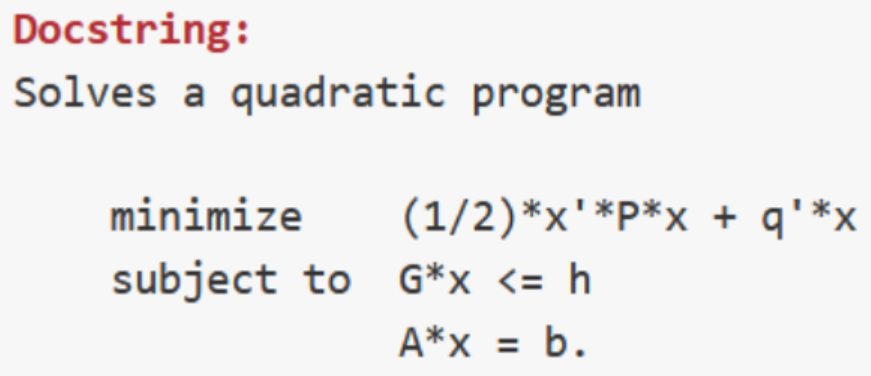

In [272]:

# Global Minimum Variance (GMV) -- numerical
# from cvxopt import matrix, solvers

# P = matrix(np.array(mvo1_cov))
# q = matrix(np.zeros((len(mvo1_cov), 1))) #cvxopt.matrix of 0s of shape (7, 1)
# A = matrix(1.0, (1, len(assets))) #cvqopt.matrix of 1s of shape (1, 7) 
# b = matrix(1.0) #1x1 matrix of 1
# w_gmv_v2 = np.array(solvers.qp(P, q, A=A, b=b, h = 0.09/252, G = mvo1_mean)['x']) #minimizes volatility such that sum of x = 1
# w_gmv_df_v2 = pd.DataFrame(w_gmv_v2).transpose()
# w_gmv_df_v2.columns = assets
# stdev_gmv_v2 = np.sqrt(np.dot(w_gmv_v2.T, np.dot(hist_cov, w_gmv_v2))) * np.sqrt(250)
# print(w_gmv_df_v2)
# # print(np.asscalar(stdev_gmv_v2))

##### Maximize returns by putting a constraint on volatility and the portfolio constituents

What you want here, to maximize return subject to a target risk, is a quadraticaly constrained quadratic program (QCQP), looking like:

In [209]:
#for maximizing objective we return -1 of objective
def objective(w, cov):
    
    x = (np.matmul(w.T, mvo1_mean))    
    return x*-1

def variance(w, cov):
    var = np.sqrt(np.matmul(w.T, np.matmul(cov, w)))
    return var

In [149]:
# https://stackoverflow.com/questions/44515880/scipy-portfolio-optimization-with-industry-level-constraints

In [252]:
from scipy.optimize import minimize

#constraints and tolerance defined below
#initially creating an equal weight portfolio
w = np.array([1/len(mvo1_cov) for i in range(len(mvo1_cov))])
var = np.sqrt(np.matmul(w.T, np.matmul(mvo1_cov, w)))

tolerance_var = 0.8594
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0}, 
        #{'type': 'ineq', 'fun': lambda w: w},#this will put another constraint that all positions must be positive or we are building long only portfolio
        {'type': 'ineq', 'fun': lambda x: -variance(x, mvo1_cov) + tolerance_var}) #constraint is var < tolerance_var, hence -var + tolerance_var > 0
TOL = 1e-12    
res = minimize(objective, w, args = mvo1_cov, method='SLSQP', 
               constraints=cons, tol=TOL, options={'disp': True})
res


# SLSQP: Sequential Least Squares Programming algorithm
# minimize(fun,x0,args=(),method=SLSQP,jac=None)
# fun: The objective function to be maximized with a negative sign so optimizer works to maximize returns here.
# x0: Initial guess
# args(): Extra arguments passed to the objective function and its derivatives (`fun`, `jac` and `hess` functions).
# for SLSQP constraints are defined in a particular format , see documentation
# disp : bool -> Set to True to print convergence messages.

Optimization terminated successfully    (Exit mode 0)
            Current function value: -58.253241031485565
            Iterations: 23
            Function evaluations: 185
            Gradient evaluations: 19


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -58.253241031485565
       x: [ 5.022e+00 -4.615e-01  2.188e+00 -1.497e+00 -1.417e+00
            3.689e+00 -7.419e+00  8.954e-01]
     nit: 23
     jac: [-3.150e+00 -1.750e+00  6.390e+00  2.860e+00  6.750e+00
            5.400e-01  6.750e+00  5.260e+00]
    nfev: 185
    njev: 19

In [253]:
final_returns = np.matmul(res.x, mvo1_mean.T)
final_returns

58.253241031485565

In [254]:
np.matmul(res.x.T, np.matmul(mvo1_cov, res.x))

0.7385683600104573

In [168]:
#res.x results above do not match with solver in excel as explained in the module

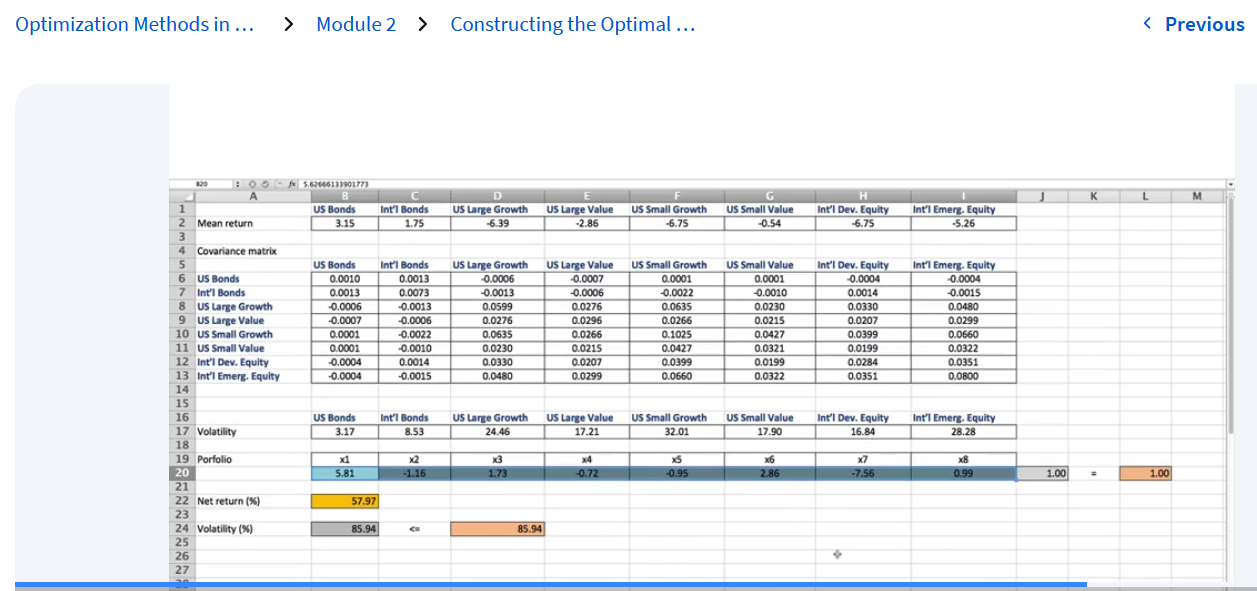

In [255]:
#couldn't get answer using cvxopt
from cvxopt import matrix, solvers


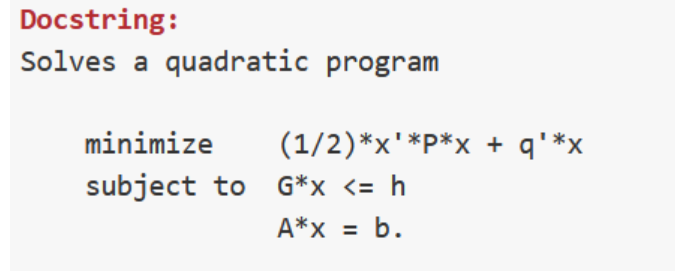

In [256]:
# Maximum return -- numerical
mu_o = np.max(mvo1_mean)
one_vec = np.ones(len(mvo1_cov))
P = matrix(np.array(mvo1_cov))
q = matrix(np.zeros((len(mvo1_cov), 1)))
A = matrix(np.hstack([np.array(mvo1_mean).reshape(len(mvo1_cov),1),one_vec.reshape(len(mvo1_cov),1)]).transpose())
b = matrix([mu_o,1])
w_max_ret_v2 = np.array(solvers.qp(P, q, A=A, b=b)['x'])
# w_max_ret_df_v2 = pd.DataFrame(w_max_ret_v2).transpose()
# w_max_ret_df_v2.columns = mvo1.columns
print(w_max_ret_df_v2)

          0         1         2         3         4         5         6  \
0  1.060822 -0.097337  0.020904  0.017663 -0.038403  0.023854  0.011918   

         7  
0  0.00058  


In [192]:
# solvers.cpl()
# solvers.socp()

In [227]:
np.matmul(w_max_ret_df_v2, mvo1_mean.T)

0    3.15
dtype: float64

In [228]:
res.x

array([ 5.02217376, -0.46151446,  2.18825324, -1.49723351, -1.41678532,
        3.68904642, -7.41929756,  0.89535742])

In [248]:
# https://medium.com/the-modern-scientist/how-to-select-your-mpf-portfolio-wisely-portfolio-optimization-53c9b86621b2
import cvxpy as cp

# set your own parameter: e.g. my expected max volatility
vol_max = 0.8594

# create cvxpy variable to minimize
w = cp.Variable(len(mvo1_mean))


# construct the objective function and constraints
obj = cp.Maximize(w.T @ mvo1_mean)
const = [
    cp.sum(w) == 1, 
     (w.T @ mvo1_cov @ w) <= vol_max
]

# solve it!
prob = cp.Problem(obj, const)
opt_v = prob.solve()

# risk_opt = (opt_v * 252) ** 0.5
# w_opt = w.value

# print('optimal risk (%):', risk_opt)
# print('optimal proportion:', np.round(w_opt, 4))

In [241]:
opt_v

62.63373494330527

In [242]:
w.value

array([ 5.33708772, -0.49046665,  2.36054909, -1.6176615 , -1.52636109,
        3.98041398, -8.01005001,  0.96648847])

In [245]:
np.matmul(w.value.T,np.matmul(mvo1_cov,w.value))

0.8593999999686324

In [246]:
np.matmul(w.value.T,mvo1_mean)

62.63373494330527